# Quantum Circuit Discovery with Mellea + Ollama

This notebook demonstrates how to use **Mellea agents** with a **local Ollama LLM**
to discover and evaluate novel quantum circuits.


In [2]:
# Install dependencies (run once)
!pip install mellea qiskit qiskit-aer numpy matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.7 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/8.1 MB 1.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.4 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.2 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.2 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.1 MB 1.2 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.1 MB 1.2 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ----------- ---------------------------- 2.4/8.1 MB 1.0 MB/s eta 0:00:06
   ----------- -----------------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Ollama + Mellea Configuration

Ensure Ollama is running locally with the Granite model:
```bash
ollama serve
ollama pull granite3.3:2b
```

**Note:** You can also use other models like `granite4:tiny-h` or `llama3.2:3b`

In [5]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import mellea


In [6]:
# Start a Mellea session with Ollama backend
session = mellea.start_session(
    backend_name="ollama",
    model_id="granite3.3:2b",
)

=== 14:39:11-INFO ======
Starting Mellea session: backend=ollama, model=granite3.3:2b, context=SimpleContext


## Quantum Circuit JSON Schema


In [7]:
CIRCUIT_SCHEMA = """
You must output a quantum circuit as valid JSON:
{
  \"num_qubits\": <int>,
  \"gates\": [
    {\"name\": \"h\", \"targets\": [0]},
    {\"name\": \"cx\", \"control\": 0, \"target\": 1},
    {\"name\": \"rz\", \"targets\": [1], \"theta\": \"pi/4\"}
  ]
}

Allowed gates:
- h, x, y, z
- rx, ry, rz (theta required)
- cx, cz
- measure
"""


## Circuit Generator Agent


In [14]:
# System prompt for circuit generation
GENERATOR_SYSTEM_PROMPT = f"""
You are a quantum algorithms researcher.

Your goal:
- Propose novel, compact quantum circuits
- Focus on entanglement, interference, or variational structure
- Avoid textbook circuits (Bell, GHZ, QFT)

Constraints:
- 2–5 qubits
- <= 12 gates
- Output JSON ONLY (no markdown, no explanation)

{CIRCUIT_SCHEMA}
"""

def generate_circuit(goal: str) -> str:
    """Generate a quantum circuit using Mellea."""
    full_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Task: Design a quantum circuit for: {goal}

Respond with valid JSON only, no explanation."""
    
    response = session.instruct(full_prompt)
    return str(response)

## Circuit Critic Agent


In [15]:
# System prompt for circuit critique
CRITIC_SYSTEM_PROMPT = """
You are a skeptical quantum computing reviewer.

Given a quantum circuit:
- Assess novelty
- Assess potential algorithmic usefulness
- Identify redundancies
- Suggest improvements

Respond in JSON only (no markdown):
{
  "novelty_score": 0-10,
  "usefulness_score": 0-10,
  "comments": "...",
  "suggested_changes": "..."
}
"""

def critique_circuit(spec: dict, counts: dict) -> str:
    """Critique a quantum circuit using Mellea."""
    full_prompt = f"""{CRITIC_SYSTEM_PROMPT}

Circuit:
{json.dumps(spec, indent=2)}

Measurement results:
{counts}

Analyze this circuit and respond with JSON only."""
    
    response = session.instruct(full_prompt)
    return str(response)

## Qiskit Evaluation Utilities


In [11]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import re
import math

def extract_json(text: str) -> str:
    """Extract JSON from LLM response (handles markdown code blocks)."""
    # Try to find JSON in code blocks first
    code_block_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', text, re.DOTALL)
    if code_block_match:
        return code_block_match.group(1)
    
    # Try to find raw JSON object
    json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', text, re.DOTALL)
    if json_match:
        return json_match.group(0)
    
    return text

def parse_theta(theta_str):
    """Parse theta value that might be a string like 'pi/4' or a number."""
    if isinstance(theta_str, (int, float)):
        return float(theta_str)
    # Handle string expressions like "pi/4", "pi/2", etc.
    theta_str = str(theta_str).strip()
    theta_str = theta_str.replace("pi", str(math.pi))
    theta_str = theta_str.replace("π", str(math.pi))
    try:
        return float(eval(theta_str))
    except:
        return math.pi / 4  # Default fallback

def build_qiskit_circuit(spec: dict) -> QuantumCircuit:
    """Build a Qiskit circuit from JSON specification."""
    qc = QuantumCircuit(spec["num_qubits"])
    
    for gate in spec.get("gates", []):
        name = gate["name"].lower()
        
        if name == "h":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.h(t)
        elif name == "x":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.x(t)
        elif name == "y":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.y(t)
        elif name == "z":
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                qc.z(t)
        elif name in ["rx", "ry", "rz"]:
            theta = parse_theta(gate.get("theta", "pi/4"))
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(theta, t)
        elif name == "cx" or name == "cnot":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            qc.cx(ctrl, tgt)
        elif name == "cz":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            qc.cz(ctrl, tgt)
    
    return qc

def simulate_circuit(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """Simulate the circuit and return measurement counts."""
    sim = AerSimulator()
    qc_with_measure = qc.copy()
    qc_with_measure.measure_all()
    job = sim.run(qc_with_measure, shots=shots)
    return job.result().get_counts()

## Discovery Loop


In [12]:
def discovery_step(goal: str):
    """Run one discovery step: generate, simulate, critique."""
    print(f"Goal: {goal}\n")
    
    # Generate circuit
    print("Generating circuit...")
    circuit_json = generate_circuit(goal)
    print(f"Raw response:\n{circuit_json}\n")
    
    # Parse JSON
    try:
        json_str = extract_json(circuit_json)
        spec = json.loads(json_str)
        print(f"Parsed circuit spec successfully")
    except json.JSONDecodeError as e:
        print(f"JSON parse error: {e}")
        print("Attempting to create a default circuit...")
        spec = {
            "num_qubits": 3,
            "gates": [
                {"name": "h", "targets": [0]},
                {"name": "cx", "control": 0, "target": 1},
                {"name": "cx", "control": 1, "target": 2}
            ]
        }
    
    # Build and simulate
    print("\nBuilding Qiskit circuit...")
    qc = build_qiskit_circuit(spec)
    print(qc.draw(output='text'))
    
    print("\nSimulating...")
    counts = simulate_circuit(qc)
    
    # Critique
    print("\nGetting critique...")
    critique = critique_circuit(spec, counts)
    
    return spec, qc, counts, critique

## Run an Example


In [20]:
# Reset session for clean demo run (optional)
session.reset()

In [21]:
# Run a discovery step
goal = "Generate high-entropy measurement distributions using minimal entanglement"

spec, qc, counts, critique = discovery_step(goal)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print("\n Circuit Specification:")
print(json.dumps(spec, indent=2))
print("\n Measurement Counts:")
print(counts)
print("\n Critique:")
print(critique)

🎯 Goal: Generate high-entropy measurement distributions using minimal entanglement

🔧 Generating circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:46:54-INFO ======
SUCCESS


  0%|          | 0/2 [00:05<?, ?it/s]


Raw response:
{
  "num_qubits": 2,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 1, "target": 0},
    {"name": "h", "targets": [1]}
  ]
}

✅ Parsed circuit spec successfully

⚛️ Building Qiskit circuit...
     ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├─────
     └───┘└─┬─┘┌───┐
q_1: ───────■──┤ H ├
               └───┘

🔬 Simulating...

📝 Getting critique...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:47:16-INFO ======
SUCCESS


  0%|          | 0/2 [00:22<?, ?it/s]


📊 RESULTS

🔹 Circuit Specification:
{
  "num_qubits": 2,
  "gates": [
    {
      "name": "h",
      "targets": [
        0
      ]
    },
    {
      "name": "cx",
      "control": 1,
      "target": 0
    },
    {
      "name": "h",
      "targets": [
        1
      ]
    }
  ]
}

🔹 Measurement Counts:
{'11': 267, '10': 249, '01': 267, '00': 241}

🔹 Critique:
{
  "novelty_score": 5,
  "usefulness_score": 8,
  "comments": "This circuit demonstrates a basic entangling operation using CX gate followed by Hadamard on the first qubit, then another Hadamard on the second qubit. This sequence is reminiscent of common quantum state preparation techniques and doesn't showcase groundbreaking novelty.",
  "suggested_changes": "1. TheCX gate with control 1 and target 0 could potentially be a controlled-NOT (CNOT) operation, which is a fundamental two-qubit gate. This would align the circuit more closely with conventional quantum computing algorithms.2. Consider adding measurements after each H

## Visualize Results

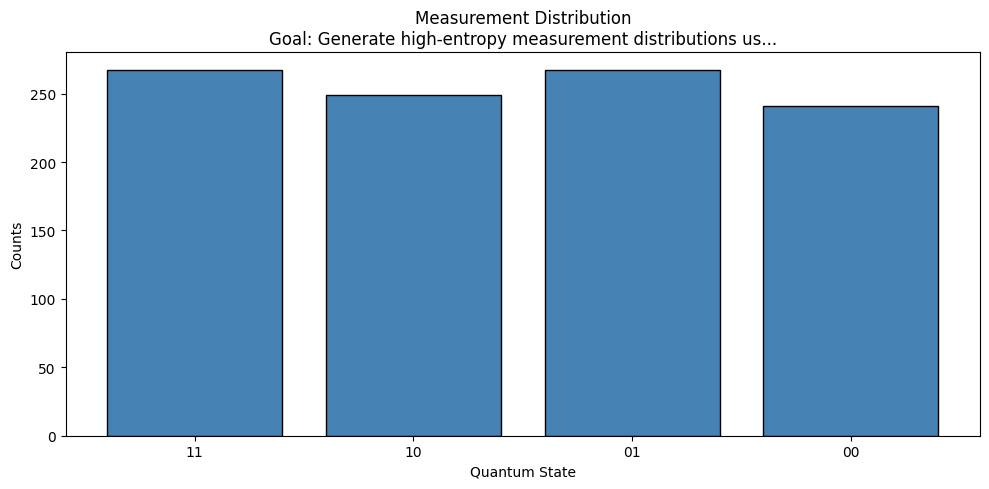

In [25]:
# Visualize the measurement distribution
def plot_counts(counts: dict, title: str = "Measurement Distribution"):
    """Plot measurement counts as a bar chart."""
    states = list(counts.keys())
    values = list(counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(states, values, color='steelblue', edgecolor='black')
    plt.xlabel('Quantum State')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(rotation=45 if len(states) > 8 else 0)
    plt.tight_layout()
    plt.show()

plot_counts(counts, f"Measurement Distribution\nGoal: {goal[:50]}...")

## Try Different Goals

Let's explore different quantum computing objectives!

🎯 Goal: Create a circuit that produces a uniform superposition over 3 qubits with phase differences

🔧 Generating circuit...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:47:33-INFO ======
SUCCESS


  0%|          | 0/2 [00:16<?, ?it/s]


Raw response:
{
  "num_qubits": 3,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "h", "targets": [1]},
    {"name": "cx", "control": 2, "target": 0},
    {"name": "cx", "control": 1, "target": 0},
    {"name": "rz", "targets": [0], "theta": "pi/4"},
    {"name": "cz", "controls": [0], "target": 1}
  ]
}

✅ Parsed circuit spec successfully

⚛️ Building Qiskit circuit...
     ┌───┐┌───┐┌───┐┌─────────┐   
q_0: ┤ H ├┤ X ├┤ X ├┤ Rz(π/4) ├─■─
     ├───┤└─┬─┘└─┬─┘└─────────┘ │ 
q_1: ┤ H ├──┼────■──────────────■─
     └───┘  │                     
q_2: ───────■─────────────────────
                                  

🔬 Simulating...

📝 Getting critique...


  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:48:00-INFO ======
SUCCESS


  0%|          | 0/2 [00:26<?, ?it/s]


📊 RESULTS

🔹 Measurement Counts:
{'000': 255, '001': 268, '011': 257, '010': 244}

🔹 Critique:
{
  "novelty_score": 5,
  "usefulness_score": 7,
  "comments": "This quantum circuit employs a combination of single-qubit Hadamard (h), controlled-U (cx), and rotation (rz) gates, which are standard in quantum computing. The use of phase-shift (cz) gate is also common for creating entanglement. However, the specific arrangement and sequence of these gates along with the theta value for rz ('pi/4') suggest a tailored application, potentially for quantum error correction or quantum algorithm like Quantum Approximate Optimization Algorithm (QAOA).",
  "suggested_changes": "1. Consider adding measurement basis specification as the current circuit doesn't specify the measurement basis (e.g., X, Z, or combination). This is crucial for accurate interpretation of results. 2. The number of shots (measurements) could be increased to reduce statistical error and improve the reliability of the output p

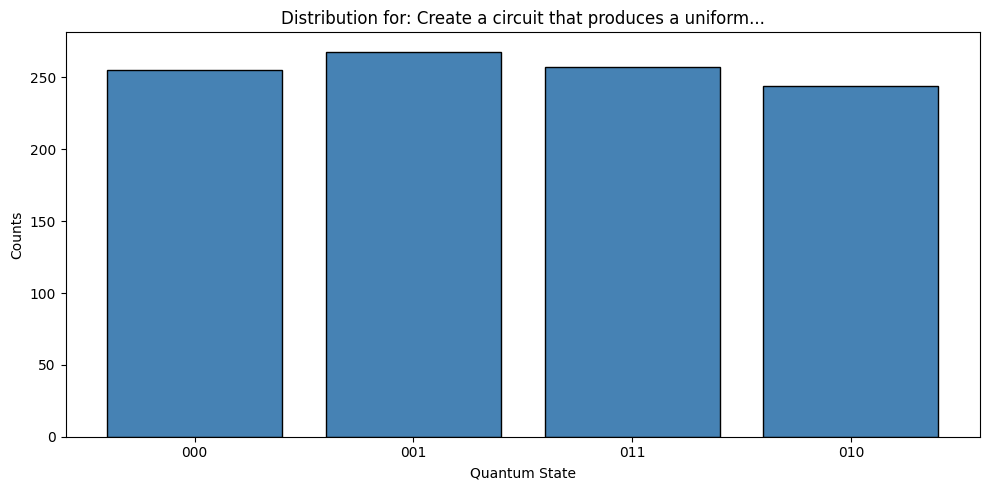

In [23]:
# Try another goal
goal2 = "Create a circuit that produces a uniform superposition over 3 qubits with phase differences"

spec2, qc2, counts2, critique2 = discovery_step(goal2)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print("\nMeasurement Counts:")
print(counts2)
print("\nCritique:")
print(critique2)

# Visualize
plot_counts(counts2, f"Distribution for: {goal2[:40]}...")

## Iterative Refinement

Use the critique to generate an improved circuit!

🔄 Refining circuit for: Generate high-entropy measurement distributions us...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 14:48:36-INFO ======
SUCCESS


  0%|          | 0/2 [00:36<?, ?it/s]

✅ Refined Circuit:
     ┌───┐┌───┐         
q_0: ┤ H ├┤ X ├─────────
     └───┘└─┬─┘┌───────┐
q_1: ───────■──┤ Rz(π) ├
               └───────┘

🔹 Refined Measurement Counts:
{'00': 510, '01': 514}


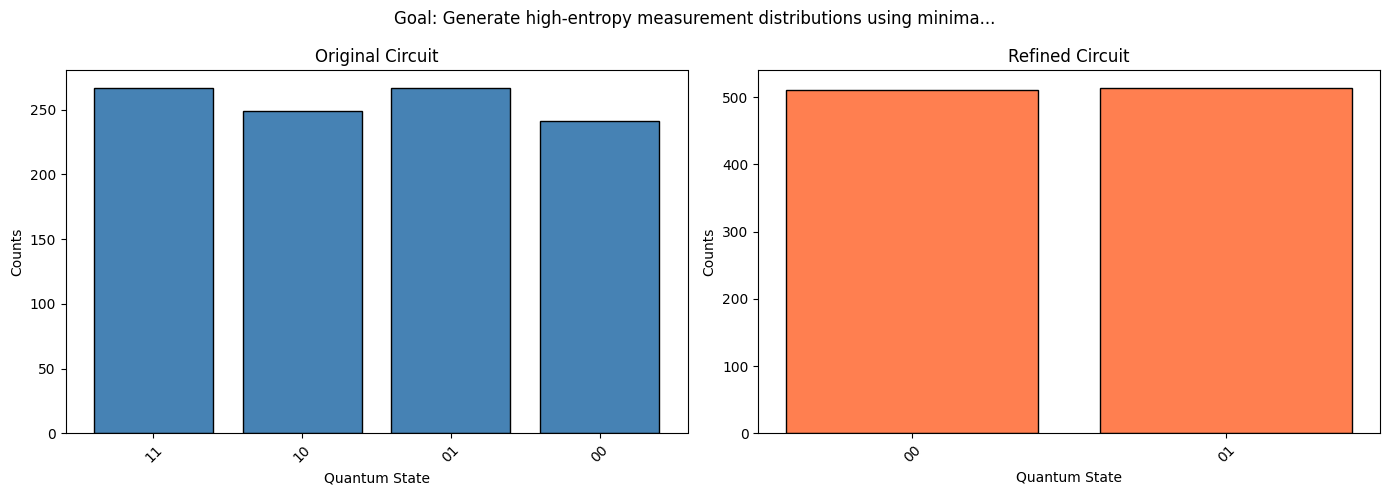

In [24]:
def refine_circuit(original_spec: dict, critique: str, goal: str) -> tuple:
    """Refine a circuit based on critique feedback."""
    
    refinement_prompt = f"""{GENERATOR_SYSTEM_PROMPT}

Original goal: {goal}

Original circuit:
{json.dumps(original_spec, indent=2)}

Critique feedback:
{critique}

Based on this critique, design an IMPROVED quantum circuit that addresses the feedback.
Keep the same goal but make the circuit better.

Respond with JSON only."""
    
    response = session.instruct(refinement_prompt)
    
    try:
        json_str = extract_json(str(response))
        new_spec = json.loads(json_str)
        new_qc = build_qiskit_circuit(new_spec)
        new_counts = simulate_circuit(new_qc)
        return new_spec, new_qc, new_counts
    except Exception as e:
        print(f"Refinement failed: {e}")
        return original_spec, None, None

# ============================================================
# Choose which example to refine (change these to use goal2, spec2, etc.)
# ============================================================
refine_goal = goal  # Use goal2 to refine the second example
refine_spec = spec  # Use spec2 to refine the second example
refine_critique = critique  # Use critique2 to refine the second example
refine_counts = counts  # Use counts2 to refine the second example

print(f"Refining circuit for: {refine_goal[:50]}...\n")
refined_spec, refined_qc, refined_counts = refine_circuit(refine_spec, refine_critique, refine_goal)

if refined_qc:
    print("Refined Circuit:")
    print(refined_qc.draw(output='text'))
    print("\nRefined Measurement Counts:")
    print(refined_counts)
    
    # Compare original vs refined
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original
    states1 = list(refine_counts.keys())
    values1 = list(refine_counts.values())
    axes[0].bar(states1, values1, color='steelblue', edgecolor='black')
    axes[0].set_title('Original Circuit')
    axes[0].set_xlabel('Quantum State')
    axes[0].set_ylabel('Counts')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Refined
    states2 = list(refined_counts.keys())
    values2 = list(refined_counts.values())
    axes[1].bar(states2, values2, color='coral', edgecolor='black')
    axes[1].set_title('Refined Circuit')
    axes[1].set_xlabel('Quantum State')
    axes[1].set_ylabel('Counts')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f"Goal: {refine_goal[:60]}...")
    plt.tight_layout()
    plt.show()
else:
    print("Refinement failed - using original circuit")

## Summary

This notebook demonstrated how to use **Mellea** with a local **Ollama LLM** to:

1. **Generate** novel quantum circuits from natural language goals
2. **Simulate** circuits using Qiskit and Aer
3. **Critique** circuits for novelty and usefulness
4. **Refine** circuits based on feedback

The Mellea framework provides a clean API for structured LLM interactions, making it easy to build AI-powered quantum algorithm discovery systems.